In [11]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #03 - Statistical Objective Analysis

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using statistical objective analysis.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [12]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
from io import StringIO
import sys

['CWPL', 'CWQI', 'CWSE', 'CYAH', 'CYBK', 'CYCB', 'CYEU', 'CYEV', 'CYFB', 'CYJT', 'CYLT', 'CYMO', 'CYPH', 'CYQD', 'CYRB', 'CYSA', 'CYSM', 'CYUX', 'CYVP', 'CYVQ', 'CYYE', 'CYYQ', 'CYYR', 'CYZT', 'CYZV', 'CZXS', 'KABQ', 'KABR', 'KADQ', 'KAGC', 'KAKN', 'KAKO', 'KALY', 'KAMA', 'KANC', 'KANN', 'KAPX', 'KBAD', 'KBET', 'KBIS', 'KBMX', 'KBNA', 'KBOI', 'KBRO', 'KBRW', 'KBUF', 'KBYH', 'KCAR', 'KCDB', 'KCHH', 'KCHS', 'KCRP', 'KDDC', 'KDEN', 'KDLF', 'KDMA', 'KDNR', 'KDRT', 'KDTX', 'KDVN', 'KEPZ', 'KEYW', 'KFAI', 'KFFC', 'KFGZ', 'KFOE', 'KFWD', 'KGGW', 'KGJT', 'KGRB', 'KGSO', 'KGYX', 'KIAD', 'KILN', 'KILX', 'KINL', 'KITO', 'KJAN', 'KJAX', 'KJSJ', 'KKPP', 'KLBF', 'KLCH', 'KLIT', 'KLKN', 'KLZK', 'KMAF', 'KMEX', 'KMFL', 'KMFR', 'KMHX', 'KMIA', 'KMPX', 'KMZT', 'KNGP', 'KNIP', 'KNKX', 'KNQX', 'KNUC', 'KOAK', 'KOAX', 'KOKC', 'KOKX', 'KOME', 'KOTX', 'KOTZ', 'KOUN', 'KPIA', 'KPIT', 'KRAP', 'KREV', 'KRIW', 'KRME', 'KRNK', 'KROL', 'KSDQ', 'KSGF', 'KSHV', 'KSIL', 'KSLC', 'KSLE', 'KSNP', 'KTBW', 'KTFX', 'KTLH',

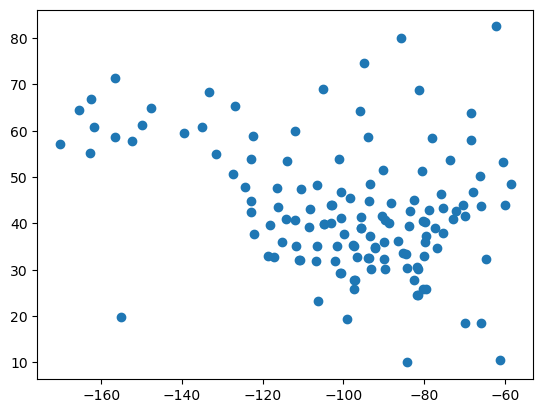

In [13]:
### Read in observations ###
with open("RAOBs_201903131200.txt") as file:
    data = file.read()

stn_name = [a.split(',')[0] for a in data.split('\n')]
print(stn_name)

data = np.genfromtxt(StringIO(data), delimiter=",")
data = data[:,1:]

latitude = data[:,0]
longitude = data[:,1]
Height = data[:,2]
plt.scatter(longitude, latitude)

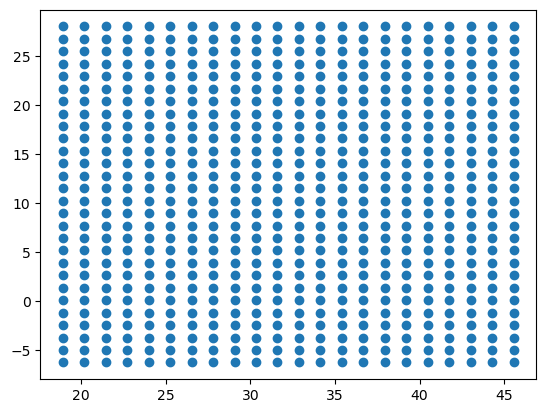

In [14]:
### Set up analysis map with a 22x28 rectangular grid of points ###
x = np.arange(22)*(1.27)+18.9
y = np.arange(28)*(1.27)-6.3

X,Y = np.meshgrid(x,y)
plt.scatter(X,Y)

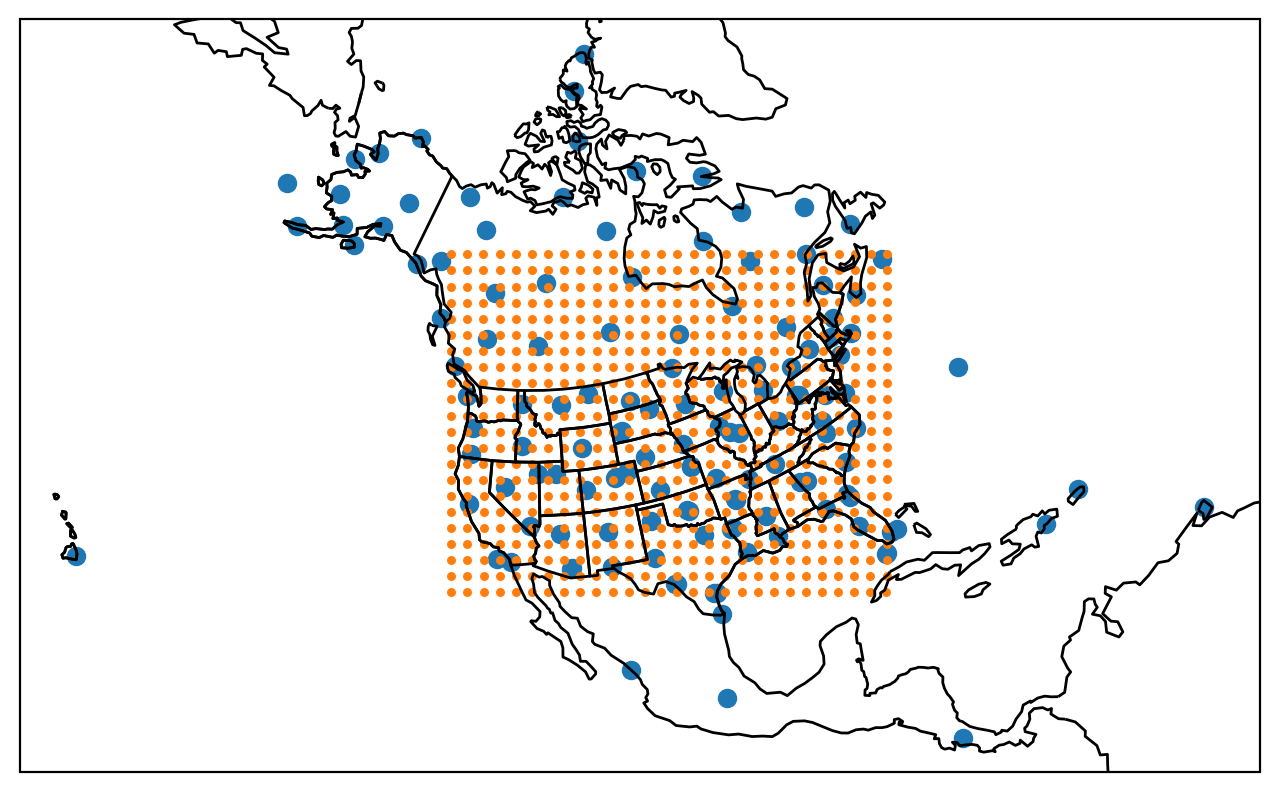

In [15]:
### convert obs lat/long to x,y ###

rho = 637100000 #radius of Earth in cm
m = 1/15000000
phi_O = 60*(np.pi / 180)
lam_O = -115*(np.pi / 180)

lat_rad = latitude*(np.pi / 180)
lon_rad = longitude*(np.pi / 180)

sigma = (1 + np.sin(phi_O)) / (1 + np.sin(lat_rad))

r = m * (rho * sigma * np.cos(lat_rad))
x_obs = r * (np.cos(lon_rad - lam_O))
y_obs = r * (np.sin(lon_rad - lam_O))

Ob_Lat = ((np.pi/2) - 2*np.arctan((np.sqrt((x_obs / m)**2+(y_obs / m)**2))/(rho*(1+np.sin(phi_O)))))*(180/np.pi)
Ob_Lon =  (np.arctan((y_obs/m)/(x_obs/m)))*(180/np.pi) - 115
Lat_Grid = ((np.pi/2) - 2*np.arctan((np.sqrt((X / m)**2+(Y / m)**2))/(rho*(1+np.sin(phi_O)))))*(180/np.pi)
Lon_Grid =  (np.arctan((Y/m)/(X/m)))*(180/np.pi) - 115

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

plt.scatter(Ob_Lon, Ob_Lat, transform = ccrs.PlateCarree())
plt.scatter(Lon_Grid, Lat_Grid, transform = ccrs.PlateCarree(), s = 5)

In [16]:
### Define function for bilinear interpolation ###

def bilinear_int(x, y, z):

    #Create Local Grid#
    Xloc = x - np.floor(x)
    Yloc = y - np.floor(y)

    #Local Analysis Values#
    Z1 = z[int(np.floor(y)), int(np.floor(x))]
    Z2 = z[int(np.ceil(y)), int(np.floor(x))]
    Z3 = z[int(np.ceil(y)), int(np.ceil(x))]
    Z4 = z[int(np.floor(y)), int(np.ceil(x))]

    #Create Function#

    left = (Z2-Z1)*(Yloc)+Z1
    right = (Z3-Z4)*(Yloc)+Z4
    Pf = (right-left)*(Xloc)+left
    
    return Pf

#Define Barnes Function#

def Barnes(dik):

    #Define Variables in Function#
    Kd = 10.8844524
    R = 12.7775892

    if dik <= R:
        B = np.exp(-(dik)**2/Kd)

    else:
        B = 0
   
    return B

'''def Barnes(dik):
    Kd = 10.8844524
    R = 12.7775892
    
    dik[dik>R] = 0
    
    dik[dik != 0] = np.exp(-(dik[dik != 0])**2/Kd)
        
    return dik'''

'def Barnes(dik):\n    Kd = 10.8844524\n    R = 12.7775892\n    \n    dik[dik>R] = 0\n    \n    dik[dik != 0] = np.exp(-(dik[dik != 0])**2/Kd)\n        \n    return dik'

In [17]:
### Indices for Bilinear Interpolation ###

#Define Indices:
Xind = (x_obs - 18.9)/1.27
Yind = (y_obs + 6.3)/1.27
print(Xind, Yind)

Xtl = np.floor(Xind)
Xbl = np.floor(Xind)
Xtr = np.ceil(Xind)
Xbr = np.ceil(Xind)

Ytl = np.ceil(Yind)
Ybl = np.floor(Yind)
Ytr = np.ceil(Yind)
Ybr = np.floor(Yind)

[ 4.91825770e+00  2.56884822e+00  5.66273103e+00  4.41190226e-01
 -1.42176831e+00 -3.54323333e+00 -1.01158525e+01 -3.53225347e+00
 -4.86552760e+00 -1.84235331e+00 -1.24154865e+01  3.21612921e+00
 -8.11444428e-01  4.81897768e+00 -7.02058209e+00  3.37967541e-01
  1.80376915e+00 -5.16739688e+00 -2.62708814e+00 -1.49558172e+00
  2.37580586e+00  1.41242926e+00 -2.89810456e+00  6.90196550e+00
 -9.64518360e-03  5.26728985e+00  1.72221666e+01  9.61569779e+00
 -5.48880490e-01  8.73721303e+00 -1.79939466e+00  1.34935347e+01
  5.14687015e+00  1.65788015e+01 -1.74212169e+00  3.96730676e+00
  6.85758436e+00  1.69950462e+01 -3.74614271e+00  9.07935207e+00
  1.41736197e+01  1.30105339e+01  1.18790629e+01  2.23608963e+01
 -7.20988905e+00  7.02362927e+00  1.39317772e+01  1.93920009e+00
 -1.71976558e+00  4.90846607e+00  1.29320415e+01  2.10430302e+01
  1.46547326e+01  1.38411857e+01  2.04768779e+01  1.94971225e+01
  1.39025322e+01  2.05081231e+01  8.39549315e+00  1.06275322e+01
  1.94399362e+01  1.86362

Text(0.5, 1.0, '500 mb Analysis Barnes (gpm)')

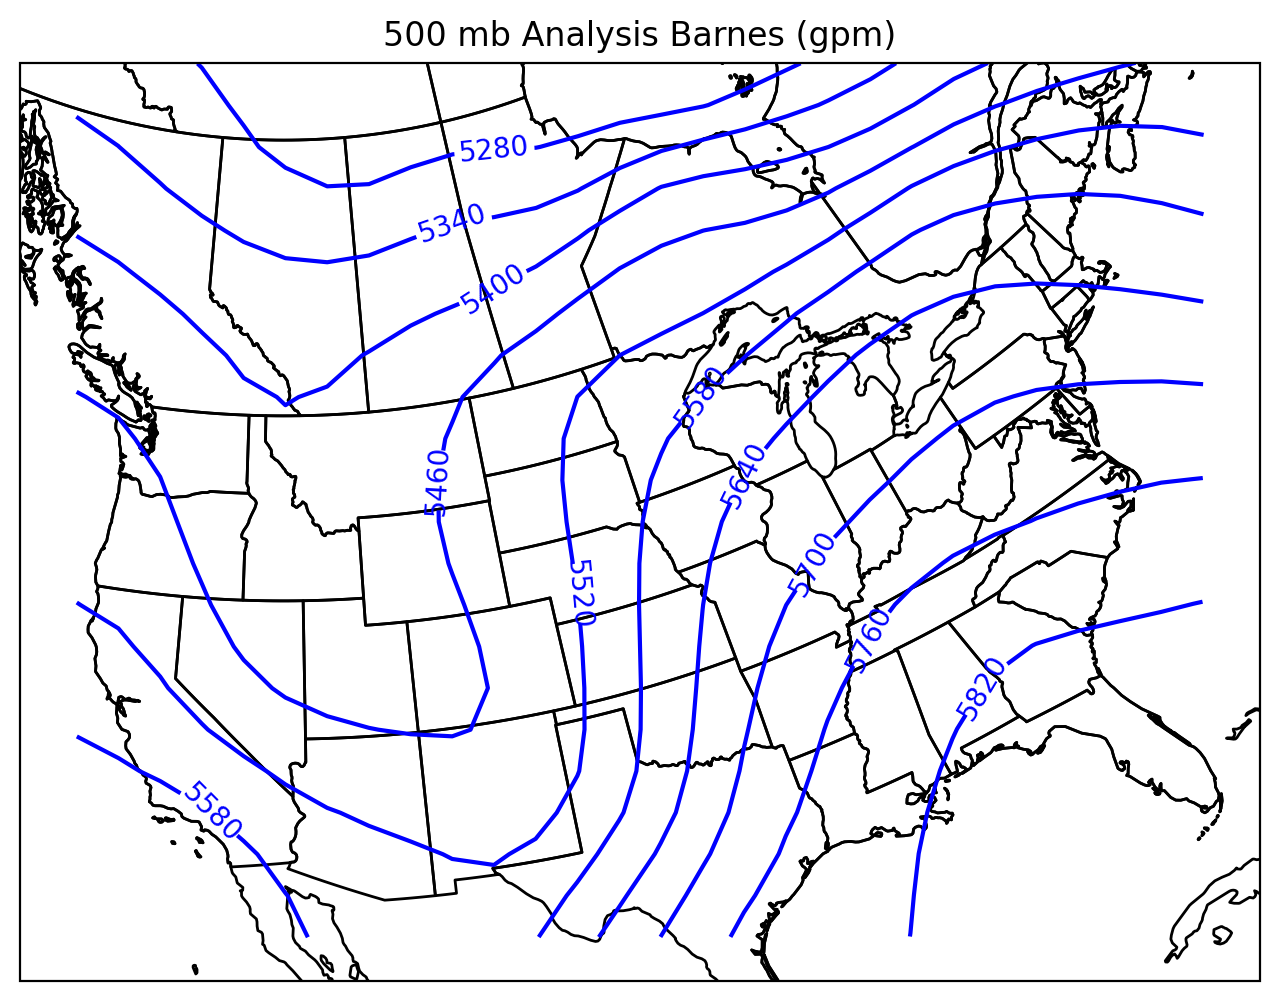

In [18]:
#Create Background Field#

Farray = np.zeros((len(y),len(x)))
for i in range(len(X)):
    for j in range(len(X[i])):
        xk = X[i,j] - x_obs
        yk = Y[i,j] - y_obs
        dik = np.sqrt((xk**2)+(yk**2))
            #for k in range(len(dik)):
        B_Array = np.asarray([Barnes(x) for x in dik])
        #Create Background Array#
        #B_Array = np.array(Barnes(dik))
        A = np.sum(B_Array*Height)/np.sum(B_Array)
        Farray[i,j] = A
### Plot 500mb analyses over a map ###
#use old code...

#Map 1#
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(Lon_Grid,Lat_Grid,Farray,colors='Blue', levels=np.arange(0,8000,60), transform=ccrs.PlateCarree())
ax1.clabel(cs1)
plt.title('500 mb Analysis Barnes (gpm)')
plt.savefig("Background_Analysis.PNG", dpi = 250)

Text(0.5, 1.0, '1st Analysis (gpm)')

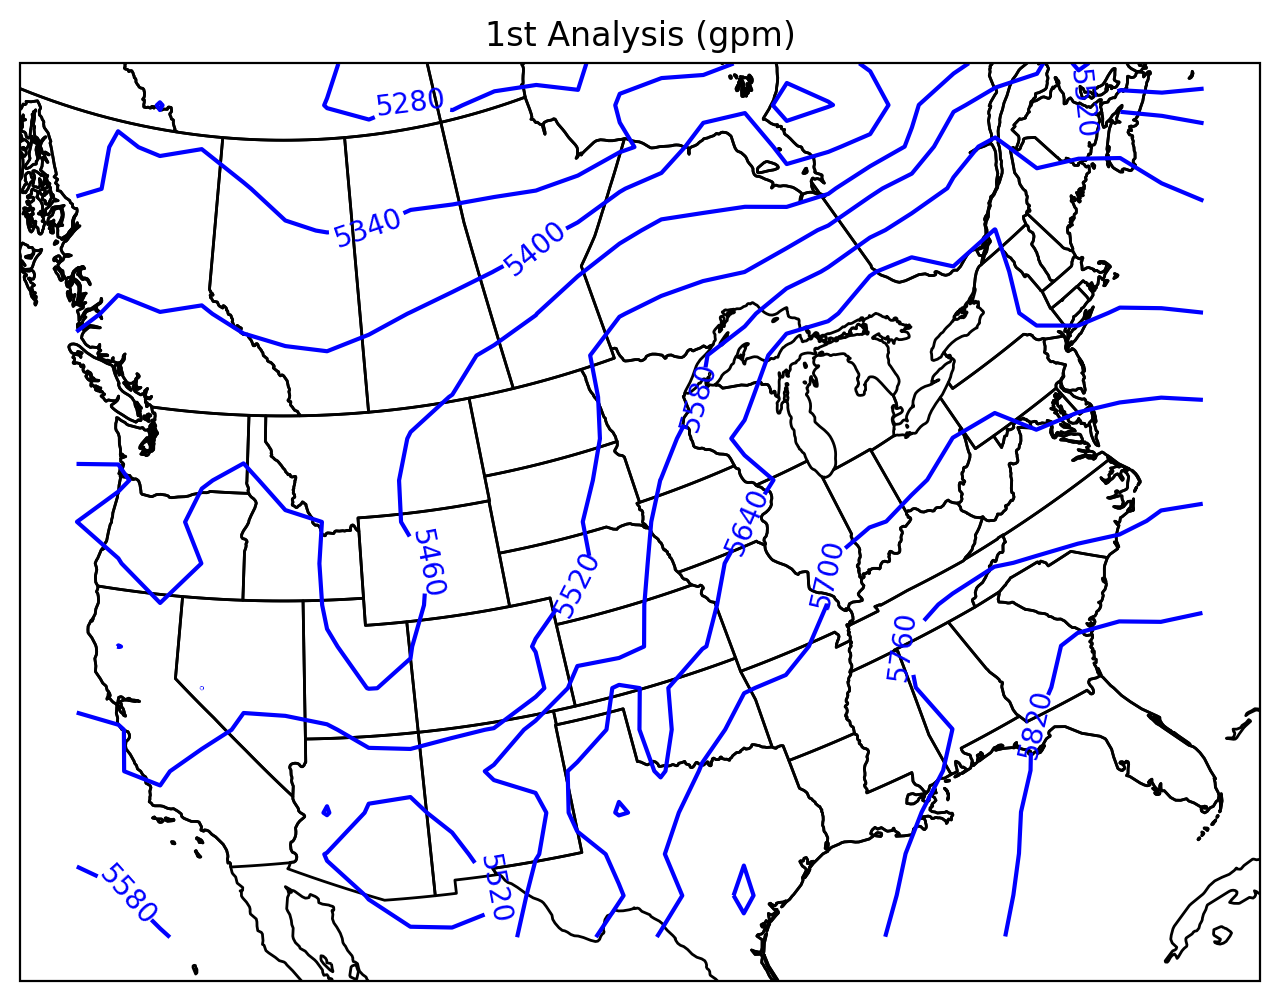

In [19]:
#First Analysis for N=2#

ROI = 12.7775892
bi_int_lst = []
Farray1st = np.zeros((len(y),len(x)))

for i in range(len(X)):
    for j in range(len(X[i])):
                xk = X[i,j] - x_obs
                yk = Y[i,j] - y_obs
                dik = np.sqrt((xk**2)+(yk**2))

                #Correlation Values N=2
                s = dik*1E-8 / m
                sort_ind = s.argsort()
                these_s = s[sort_ind[:2]]
                these_x_obs = xk[sort_ind[:2]]
                these_y_obs = yk[sort_ind[:2]]
                mag_obs_kl = np.sqrt((these_x_obs[1] - these_x_obs[0])**2 + (these_y_obs[1] - these_y_obs[0])**2)
                Corrik = 0.95*(np.exp(-1.24*((1+np.sin(np.radians(40)))/(1+np.sin(np.radians(60))))*(these_s**2)))

                #Create New Matrix#
                kl_MAT = np.zeros((2,2))
                kl_MAT[0,0] = 1
                kl_MAT[1,1] = 1
                kl_MAT[0,1] = 0.95*(np.exp(-1.24*(mag_obs_kl)**2))
                kl_MAT[1,0] = 0.95*(np.exp(-1.24*(mag_obs_kl)**2))

                #Weights#
                W = np.matmul(np.linalg.inv(kl_MAT), Corrik)
                ind = [sort_ind[0], sort_ind[1]]
                A_list = []
                for k in ind:
                    if (0<Xind[k]<21) and (0<Yind[k]<27):
                        New = bilinear_int(Xind[k], Yind[k], Farray)
                    else:
                        x_loc = x_obs[k] - X
                        y_loc = y_obs[k] - Y
                        mag_loc = np.sqrt((x_loc)**2 + (y_loc)**2)
                        M_array = np.where(mag_loc <= ROI)
                        w_loc = np.zeros((X.shape))
                        for p in M_array[0]:
                            for z in M_array[1]:
                                w_loc[p,z] = Barnes(mag_loc[p,z])
                        New = np.nansum(w_loc*Farray)/np.nansum(w_loc)
                    A_list += [New]
                A_array = np.array([[A_list[0]], [A_list[1]]])
                H_array = np.array([[Height[sort_ind[0]]], [Height[sort_ind[1]]]])
                W = W.flatten()
                A_array = A_array.flatten()
                H_array = H_array.flatten()
                F_New = np.nansum(W*(A_array - H_array))
                Farray1st[i,j] = Farray[i,j] + F_New

#Map the Analysis#
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(Lon_Grid,Lat_Grid,Farray1st,colors='Blue', levels=np.arange(0,8000,60), transform=ccrs.PlateCarree())
ax1.clabel(cs1)
plt.title('1st Analysis (gpm)')
plt.savefig("1st_Analysis.PNG", dpi = 250)

C:\Users\Mark McGarry\AppData\Local\Temp\ipykernel_7824\3522302243.py:14: RuntimeWarning: divide by zero encountered in divide
  s = dik*1E-8 / m


Text(0.5, 1.0, '2nd Analysis (gpm)')

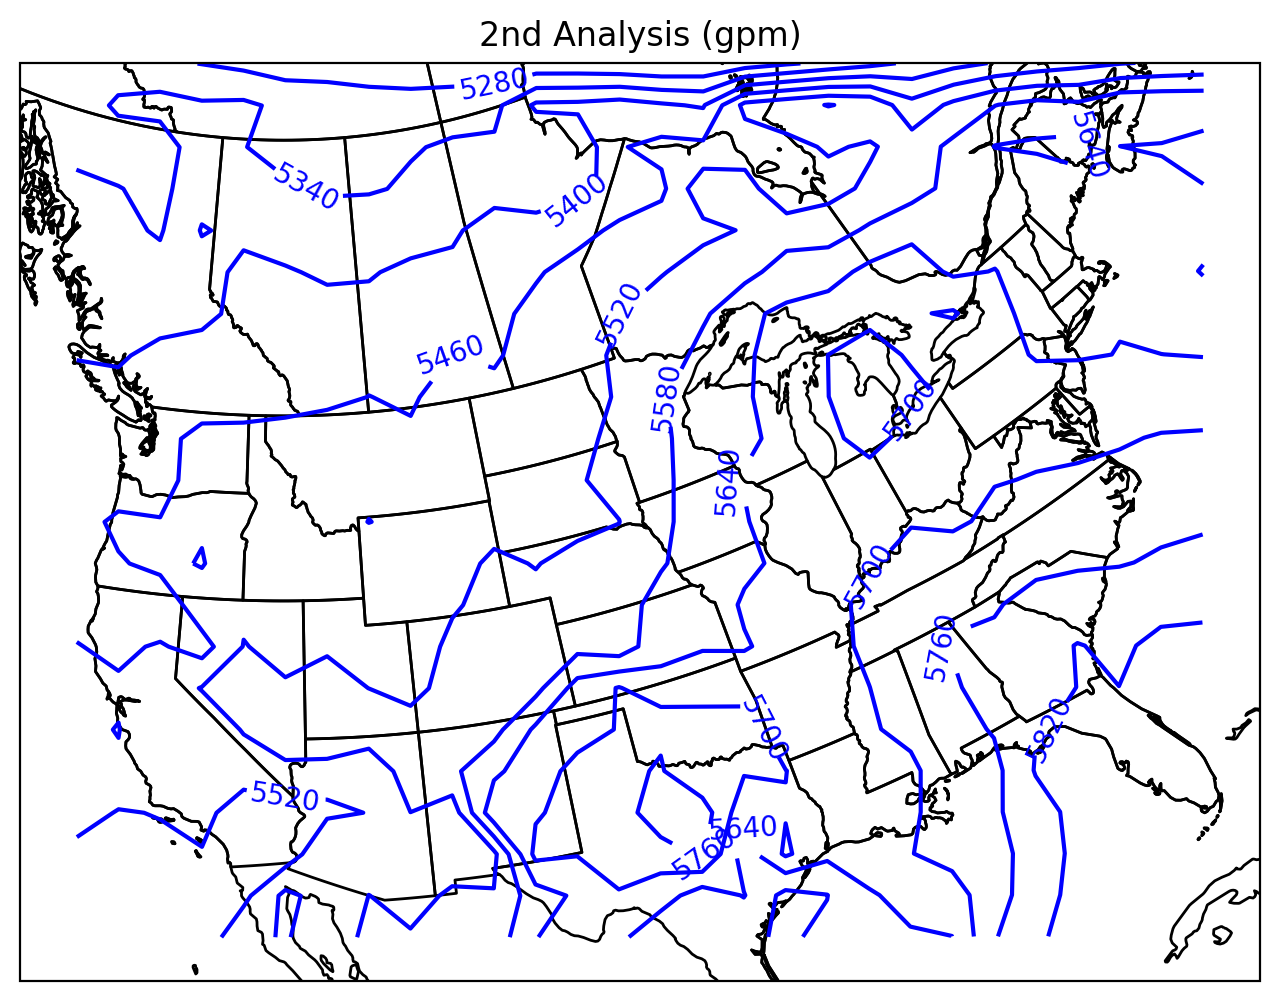

In [20]:
#Second Analysis for N=4#

ROI = 12.7775892
bi_int_lst = []
Farray2nd = np.zeros((len(y),len(x)))

for l in range(len(X)):
    for m in range(len(X[l])):
                xk = X[l,m] - x_obs
                yk = Y[l,m] - y_obs
                dik = np.sqrt((xk**2)+(yk**2))

                #Correlation Values N=4
                s = dik*1E-8 / m
                sort_ind = s.argsort()
                these_s = s[sort_ind[:4]]
                these_x_obs = xk[sort_ind[:4]]
                these_y_obs = yk[sort_ind[:4]]
                mag_obs_kl = np.sqrt((these_x_obs[1] - these_x_obs[0])**2 + (these_y_obs[1] - these_y_obs[0])**2 + (these_x_obs[2]-these_x_obs[1])**2
                                    + (these_y_obs[2] - these_y_obs[1])**2 + (these_x_obs[3] - these_x_obs[2])**2 + (these_y_obs[3] - these_y_obs[2])**2
                                    + (these_x_obs[2] - these_x_obs[0])**2 + (these_y_obs[2] - these_y_obs[0])**2 + (these_x_obs[0] - these_x_obs[2])**2
                                    + (these_y_obs[0] - these_y_obs[2])**2 + (these_x_obs[2] - these_x_obs[3])**2 + (these_y_obs[2] - these_y_obs[3])**2
                                    + (these_x_obs[1] - these_x_obs[2])**2 + (these_y_obs[1] - these_y_obs[2])**2 + (these_x_obs[0] - these_x_obs[3])**2
                                    + (these_y_obs[0] - these_y_obs[3])**2 + (these_x_obs[3] - these_x_obs[0])**2 + (these_y_obs[3] - these_y_obs[0])**2
                                    + (these_x_obs[3] - these_x_obs[1])**2 + (these_y_obs[3] - these_y_obs[1])**2 + (these_x_obs[1] - these_x_obs[3])**2
                                    + (these_y_obs[1] - these_y_obs[3])**2)
                Corrik2 = 0.95*(np.exp(-1.24*((1+np.sin(np.radians(40)))/(1+np.sin(np.radians(60))))*(these_s**2)))

                #Create New Matrix#
                kl_MAT2 = np.zeros((4,4))
                kl_MAT2[0,0] = 1
                kl_MAT2[1,1] = 1
                kl_MAT2[2,2] = 1
                kl_MAT2[3,3] = 1
                kl_MAT2[0,1] = 0.95*(np.exp(-1.24*(mag_obs_kl)**2))
                kl_MAT2[1,0] = 0.95*(np.exp(-1.24*(mag_obs_kl)**2))
                kl_MAT2[0,2] = 0.95*(np.exp(-1.24*(mag_obs_kl)**2))
                kl_MAT2[1,2] = 0.95*(np.exp(-1.24*(mag_obs_kl)**2))
                kl_MAT2[2,1] = 0.95*(np.exp(-1.24*(mag_obs_kl)**2))
                kl_MAT2[2,0] = 0.95*(np.exp(-1.24*(mag_obs_kl)**2))
                kl_MAT2[0,3] = 0.95*(np.exp(-1.24*(mag_obs_kl)**2))
                kl_MAT2[1,3] = 0.95*(np.exp(-1.24*(mag_obs_kl)**2))
                kl_MAT2[2,3] = 0.95*(np.exp(-1.24*(mag_obs_kl)**2))
                kl_MAT2[3,0] = 0.95*(np.exp(-1.24*(mag_obs_kl)**2))
                kl_MAT2[3,1] = 0.95*(np.exp(-1.24*(mag_obs_kl)**2))
                kl_MAT2[3,2] = 0.95*(np.exp(-1.24*(mag_obs_kl)**2))

                #Weights#
                W = np.matmul(np.linalg.inv(kl_MAT2), Corrik2)
                ind = [sort_ind[0], sort_ind[1], sort_ind[2], sort_ind[3]]
                A_list = []
                for k in ind:
                    if (0<Xind[k]<21) and (0<Yind[k]<27):
                        New = bilinear_int(Xind[k], Yind[k], Farray)
                    else:
                        x_loc = x_obs[k] - X
                        y_loc = y_obs[k] - Y
                        mag_loc = np.sqrt((x_loc)**2 + (y_loc)**2)
                        M_array = np.where(mag_loc <= ROI)
                        w_loc = np.zeros((X.shape))
                        for p in M_array[0]:
                            for z in M_array[1]:
                                w_loc[p,z] = Barnes(mag_loc[p,z])
                        New = np.nansum(w_loc*Farray)/np.nansum(w_loc)
                    A_list += [New]
                A_array2 = np.array([[A_list[0]], [A_list[1]], [A_list[2]], [A_list[3]]])
                H_array2 = np.array([[Height[sort_ind[0]]], [Height[sort_ind[1]]], [Height[sort_ind[2]]], [Height[sort_ind[3]]]])
                W = W.flatten()
                A_array2 = A_array2.flatten()
                H_array2 = H_array2.flatten()
                F_New = np.nansum(W*(A_array2 - H_array2))
                Farray2nd[l,m] = Farray[l,m] + F_New

#Map the Analysis#
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(Lon_Grid,Lat_Grid,Farray2nd,colors='Blue', levels=np.arange(0,8000,60), transform=ccrs.PlateCarree())
ax1.clabel(cs1)
plt.title('2nd Analysis (gpm)')
plt.savefig("2nd_Analysis.PNG", dpi = 250)

In [21]:
#Third Analysis for N=10#

ROI = 12.7775892
bi_int_lst = []
Farray3rd = np.zeros((len(y),len(x)))

for l in range(len(X)):
    for m in range(len(X[l])):
                xk = X[l,m] - x_obs
                yk = Y[l,m] - y_obs
                dik = np.sqrt((xk**2)+(yk**2))

                #Correlation Values N=4
                s = dik*1E-8 / m
                sort_ind = s.argsort()
                these_s = s[sort_ind[:10]]
                these_x_obs = xk[sort_ind[:10]]
                these_y_obs = yk[sort_ind[:10]]
                mag_obs_kl = np.sqrt((these_x_obs)**2 + (these_y_obs)**2)
                Corrik3 = 0.95*(np.exp(-1.24*((1+np.sin(np.radians(40)))/(1+np.sin(np.radians(60))))*(these_s**2)))

                #Create New Matrix#
                kl_MAT3 = np.zeros((10,10))
                for y in range(len(kl_MAT3)):
                    for v in range(len(kl_MAT3)):
                        if y == v:
                            kl_MAT3[y,v] = 1
                        else:
                            kl_MAT3[y,v] = 0.95*(np.exp(-1.24*(mag_obs_kl)**2))

                #Weights#
                W = np.matmul(np.linalg.inv(kl_MAT3), Corrik3)
                ind = [sort_ind[0], sort_ind[1], sort_ind[2], sort_ind[3], sort_ind[4], sort_ind[5], sort_ind[6], sort_ind[7], sort_ind[8], sort_ind[9]]
                A_list = []
                for k in ind:
                    if (0<Xind[k]<21) and (0<Yind[k]<27):
                        New = bilinear_int(Xind[k], Yind[k], Farray)
                    else:
                        x_loc = x_obs[k] - X
                        y_loc = y_obs[k] - Y
                        mag_loc = np.sqrt((x_loc)**2 + (y_loc)**2)
                        M_array = np.where(mag_loc <= ROI)
                        w_loc = np.zeros((X.shape))
                        for p in M_array[0]:
                            for z in M_array[1]:
                                w_loc[p,z] = Barnes(mag_loc[p,z])
                        New = np.nansum(w_loc*Farray)/np.nansum(w_loc)
                    A_list += [New]
                A_array3 = np.array([[A_list[0]], [A_list[1]], [A_list[2]], [A_list[3]], [A_list[4]], [A_list[5]], [A_list[6]], [A_list[7]], [A_list[8]],
                                    [A_list[9]]])
                H_array3 = np.array([[Height[sort_ind[0]]], [Height[sort_ind[1]]], [Height[sort_ind[2]]], [Height[sort_ind[3]]], [Height[sort_ind[4]]],
                                   [Height[sort_ind[5]]], [Height[sort_ind[6]]], [Height[sort_ind[7]]], [Height[sort_ind[8]]], [Height[sort_ind[9]]]])
                W = W.flatten()
                A_array3 = A_array3.flatten()
                H_array3 = H_array3.flatten()
                F_New = np.nansum(W*(A_array3 - H_array3))
                Farray3rd[l,m] = Farray[l,m] + F_New

#Map the Analysis#
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(Lon_Grid,Lat_Grid,Farray3rd,colors='Blue', levels=np.arange(0,8000,60), transform=ccrs.PlateCarree())
ax1.clabel(cs1)
plt.title('3rd Analysis (gpm)')
plt.savefig("3rd_Analysis.PNG", dpi = 250)

C:\Users\Mark McGarry\AppData\Local\Temp\ipykernel_7824\122313598.py:14: RuntimeWarning: divide by zero encountered in divide
  s = dik*1E-8 / m


ValueError: setting an array element with a sequence.

In [22]:
#RMSE Values

#RMSE 1

RMSE1 = np.sqrt((np.nansum((A_array-H_array)**2)/np.sum(~np.isnan(A_array))))
print(RMSE1)

#RMSE2

RMSE2 = np.sqrt((np.nansum((A_array2-H_array2)**2)/np.sum(~np.isnan(A_array2))))
print(RMSE2)

7.090817250832716
12.09605967979621


In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    A large trough in the western U.S. accompanied by a large ridge in the Eastern U.S.

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    The 1st analysis appears to be a little smoother than the 2nd analysis. The first analysis is definitely not as noisy either.
    My guess is that the more observations you have to fit in your analysis, the noisier it gets?
    

3 - What happens as you increase the number of points considered for the analysis?  Is this 
    desirable?  Why or why not? Many of the features become less and less distint as we increase our number of points in the analysis.
    This is not desirable.
    
'''

# 